In [7]:
from PIL import Image
import numpy as np
import requests
import json
import base64
from io import BytesIO
import pickle

In [21]:
# Get updated conntours from stored_contours.pkl
def get_contours():
    with open('/home/lawjarp/Projects/Caraio/magic-tool-prototype/stored_contours.pkl', 'rb') as f:
        contours = pickle.load(f)
    return contours

In [8]:
import cv2
def masks_to_contours(masks_tensors):
    """
    Convert masks (PyTorch tensors) to contours.
    Args:
        masks_tensors (list): List of PyTorch tensors representing masks.
    Returns:
        List of contours representing chromosomes.
    """
    contours_list = []
    for mask_tensor in masks_tensors[0]:
        mask = mask_tensor.cpu().permute(1,2,0).numpy()
        mask = mask[:,:,0]
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_list.extend(contours)
    return contours_list

In [9]:
def draw_contours(img, contours, colors):
    """
    Draw the contours on the image.

    Args:
        img (numpy.ndarray): The image to draw the contours on.
        contours (list): A list of contours to draw.
        colors (list): A list of colors to use for the contours.

    Returns:
        None
    """
    
    # Draw the contours on the image
    img = np.array(img)
    for i, contour in enumerate(contours):
        # Get a color from the color list using the color_map
        color = color_map[colors[i % len(colors)]]
        cv2.drawContours(img, [contour], -1, color, 1)

    # Display the image
    # Make the figure larger to see the contours better
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')  # Hide axis values
    plt.show()

In [69]:
def call_sam_with_bbox_and_points(img, bboxes, points):
    api_url = "http://3.7.234.80:8000/segment-with-bbox-and-points"
    data = {
        "images": img.tolist(),
        "bbox": bboxes,
        "points": points
    }
    response = requests.post(api_url, json=data)
    if response.status_code != 200:
        print("Error: ", response)
        return None
    masks, bboxes = pickle.loads(response.content)
    return masks, bboxes

In [27]:
# # Get skeletons of contours, use skimage
# from skimage.morphology import skeletonize
# def get_skeletons(contours):
#     skeletons = []
#     for contour in contours:
#         skeleton = skeletonize(contour)
#         skeletons.append(skeleton)
#     return skeletons

In [10]:
# Configs
# List of 10 different colors to cylce through when plotting
colors = ['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'cyan', 'magenta', 'lime']
# Map of color names to BGR values
color_map = {
    'red': (0, 0, 255),
    'green': (0, 255, 0),
    'blue': (255, 0, 0),
    'yellow': (0, 255, 255),
    'orange': (0, 165, 255),
    'purple': (128, 0, 128),
    'pink': (147, 20, 255),
    'cyan': (255, 255, 0),
    'magenta': (255, 0, 255),
    'lime': (0, 255, 0)  # Note: Lime is same as green in BGR
}

In [11]:
img  = Image.open("/home/lawjarp/Projects/Caraio/segmentation-server/app/test/test_images/6.jpg")

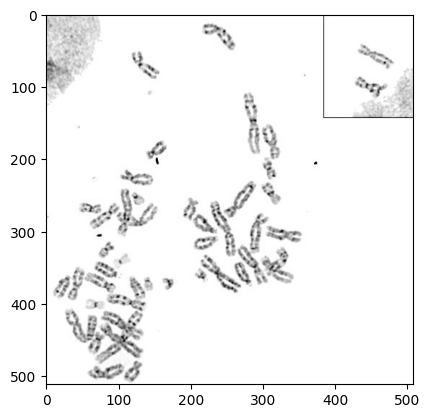

In [12]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [13]:
# Convert the image to a NumPy array
image_array = np.array(img)
# Convert the NumPy array to a list and send it to the API
api_url = "http://3.7.234.80:8000/segment"
response = requests.post(api_url, json={"images":image_array.tolist()})

In [14]:
# unpickle the response content
masks, bboxes = pickle.loads(response.content)

In [59]:
# Convert the masks to contours
contours = masks_to_contours(masks)
# Get stored contours
contours = get_contours()

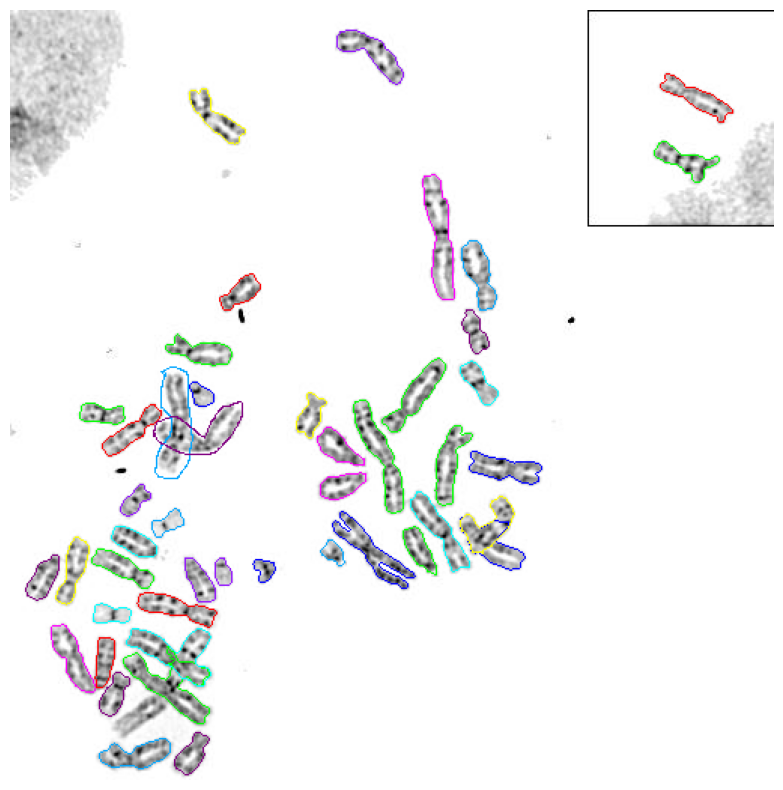

In [60]:
# Draw the contours on the image
draw_contours(img, contours, colors)

In [43]:
from skimage.morphology import medial_axis
def get_medial_axis_from_contours(image_shape, contours):
    # Create a blank binary image
    mask = np.zeros(image_shape[:2], dtype=np.uint8)  # Only take the height and width
    
    # Draw the contours onto the blank image
    cv2.drawContours(mask, [contours], -1, (255), thickness=cv2.FILLED)
    
    # Convert the binary image to boolean type for medial axis computation
    mask = mask.astype(bool)
    
    # Obtain the medial axis
    medial = medial_axis(mask)
    
    return medial

In [62]:
def medial_to_points(medial):
    """
    Convert the medial axis binary image to a list of points.

    Args:
        medial (numpy.ndarray): The binary image of the medial axis.

    Returns:
        list: A list of (y, x) coordinates denoting the medial axis points.
    """
    # Find the coordinates of all non-zero pixels
    y, x = np.where(medial)
    
    # Zip the coordinates into a list of points [[x, y], [x, y], ...]
    points = list(zip(x, y))
    points = [[int(x), int(y)] for x, y in points]
    
    return points

In [63]:
# Get medial axis from contours
medial_axes = []
for contour in contours:
    medial = get_medial_axis_from_contours(image_array.shape, contour)
    medial_axes.append(medial)
# Convert medial axes to points
medial_axes_points = []
for medial in medial_axes:
    medial_axes_points.append(medial_to_points(medial))

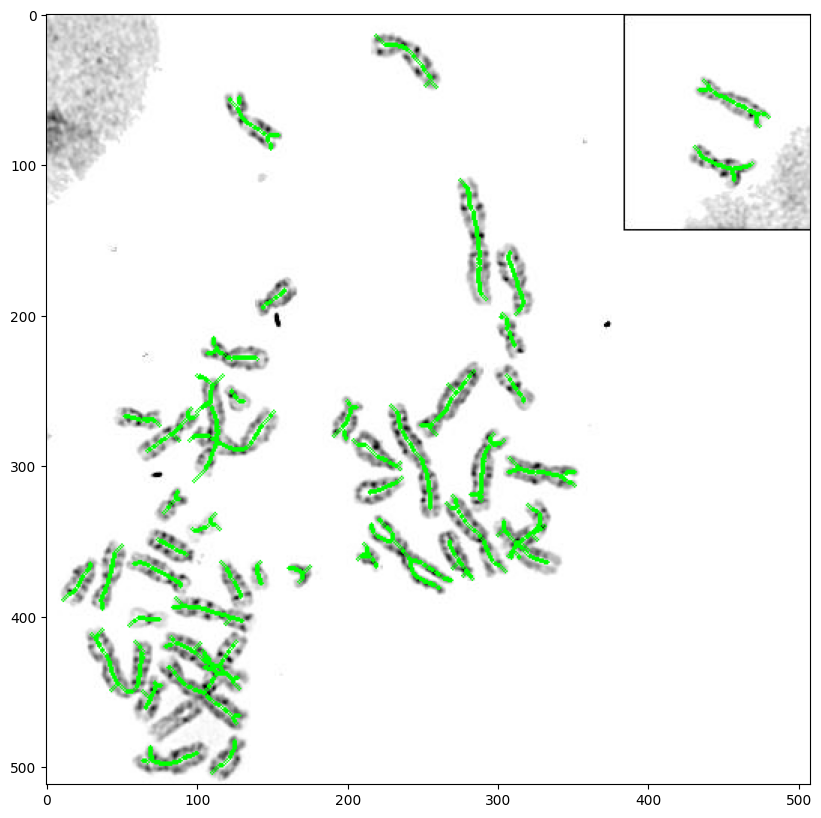

In [64]:
# Display the medial axis points on the original image
for points in medial_axes_points:
    for point in points:
        cv2.circle(image_array, tuple(point), 1, (0, 255, 0), thickness=1)
plt.figure(figsize=(10,10))
plt.imshow(image_array)

In [ ]:
def call_sam_with_bbox_and_points(img, bboxes, points):
    api_url = "http://3.7.234.80:8000/segment-with-bbox-and-points"
    data = {
        "images": img.tolist(),
        "bbox": bboxes,
        "points": points
    }
    response = requests.post(api_url, json=data)
    if response.status_code != 200:
        print("Error: ", response)
        return None
    masks, bboxes = pickle.loads(response.content)
    return masks, bboxes

In [78]:
medial_axes_points

[[[221, 336],
  [222, 337],
  [223, 338],
  [216, 339],
  [224, 339],
  [216, 340],
  [225, 340],
  [216, 341],
  [226, 341],
  [227, 341],
  [216, 342],
  [228, 342],
  [217, 343],
  [228, 343],
  [217, 344],
  [229, 344],
  [218, 345],
  [230, 345],
  [219, 346],
  [230, 346],
  [220, 347],
  [221, 347],
  [230, 347],
  [222, 348],
  [223, 348],
  [230, 348],
  [224, 349],
  [225, 349],
  [230, 349],
  [226, 350],
  [227, 350],
  [228, 350],
  [229, 350],
  [231, 350],
  [232, 351],
  [233, 352],
  [234, 353],
  [235, 354],
  [236, 355],
  [237, 356],
  [237, 357],
  [238, 358],
  [239, 359],
  [240, 360],
  [241, 361],
  [241, 362],
  [242, 363],
  [243, 363],
  [244, 363],
  [245, 363],
  [246, 363],
  [242, 364],
  [247, 364],
  [248, 364],
  [249, 364],
  [242, 365],
  [250, 365],
  [242, 366],
  [251, 366],
  [252, 366],
  [242, 367],
  [253, 367],
  [243, 368],
  [254, 368],
  [255, 368],
  [243, 369],
  [256, 369],
  [257, 369],
  [243, 370],
  [258, 370],
  [244, 371],
  [259

In [74]:
# Get masks and bboxes from SAM
masks, bboxes = call_sam_with_bbox_and_points(image_array, bboxes, medial_axes_points)

Error:  <Response [422]>


TypeError: cannot unpack non-iterable NoneType object